In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
#import time
from numpy import random
import cmath
from sympy import S, symbols, printing

from compilers import *
from utils import *
import openfermion

import json

## Hamiltonian Initialization



This section handles initialization of specific Hamiltonians and simulation parameters.

#### Arbitrary Tensored 4x4 Pauli

In [3]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, -3.0, -4.0, -2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :])
hamiltonian_list = np.array(hamiltonian_list)
pauli_hamiltonian = hamiltonian_list
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


#### Graph Hamiltonian

In [4]:
# A simple function that computes the graph distance between two sites
def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

# A simple function that initializes a graph in the form of an np.array of coordinates 
def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

#A funciton that initializes a Pauli operator in the correct space, acting on a specific qubit
def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

In [5]:
#Initialize Hamiltonian 
def graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j: #long range interaction
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j]))) 

            # if (dist(graph[i], graph[j])==1) and (i>j): #nearest neighbour interaction
            #     beta = np.random.normal()
            #     hamiltonian_list.append(beta * np.matmul(initialize_operator(Y, i, x_dim*y_dim), initialize_operator(Y, j, x_dim*y_dim)))
            
        gamma = np.random.normal()
        hamiltonian_list.append(4* gamma * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

graph_hamiltonian_list = graph_hamiltonian(3, 2, 1)
print(graph_hamiltonian_list.shape)

(36, 64, 64)


### OpenFermion Hamiltonian List Generators

In [6]:
from openfermion.hamiltonians import jellium_model
from openfermion.utils import Grid, count_qubits
from openfermion.transforms import jordan_wigner, fourier_transform, get_fermion_operator
from openfermion.linalg import eigenspectrum, qubit_operator_sparse, get_sparse_operator
from openfermion.ops import QubitOperator

#A function to help convert from the default output of openfermion to the style we require to run our simulator, 
# a numpy array that is structured as a list of hamiltonian terms. 
def openfermion_matrix_list(qubit_operator):
    total_qubits = count_qubits(qubit_operator)
    matrix_list = []
    op_list = list(qubit_operator)
    for i in op_list:
        matrix_list.append(get_sparse_operator(i, total_qubits).toarray()) #changed from qubit operator and made no differnce
    return np.array(matrix_list)

    #Test -- shows ops are equivalent
def test_list_generator(openfermion_output):
    max_val = []
    of_generator = get_sparse_operator(openfermion_output).toarray()
    list_generator = sum(openfermion_matrix_list(openfermion_output))
    the_zero_op = of_generator - list_generator
    for i in range(the_zero_op.shape[0]):
        for j in range(the_zero_op.shape[0]):
            max_val.append((the_zero_op)[i][j])
    print(max(max_val))
    norm = np.linalg.norm(the_zero_op, ord=2)
    if norm < FLOATING_POINT_PRECISION:
        print("success!")
    else:
        print("failed!")
    return 0

#### Jellium

In [7]:
#small model in 2 dimensions
grid = Grid(dimensions=1, length=5, scale=1.0)
spinless = True

# Get the momentum Hamiltonian.
momentum_hamiltonian = jellium_model(grid, spinless)
momentum_qubit_operator = jordan_wigner(momentum_hamiltonian)
momentum_qubit_operator.compress()

#Generate the matrix list
jellium_hamiltonian_list = openfermion_matrix_list(momentum_qubit_operator) #load this into simulator
print(jellium_hamiltonian_list)
print(momentum_qubit_operator)
test_list_generator(momentum_qubit_operator)

[[[ 9.81986848e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  9.81986848e+01+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  9.81986848e+01+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  ...
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    9.81986848e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  9.81986848e+01+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  9.81986848e+01+0.j]]

 [[-3.92794739e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j -3.92794739e+01+0.j  0.00000000e+00+0.j ...
    0.00

0

#### LiH, Methane, and Ethane

In [8]:
from openfermion.chem import geometry_from_pubchem
from openfermion.chem import MolecularData

basis = 'sto-3g'
multiplicity = 1

# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 4

In [9]:
#LiH
#LiH_geometry = geometry_from_pubchem('LiH')
diatomic_bond_length = 1.45
LiH_geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
print(LiH_geometry)

# Generate and populate instance of MolecularData.
LiH_molecule = MolecularData(LiH_geometry, basis, multiplicity, description="1.45")
LiH_molecule.load()

# Get the Hamiltonian in an active space.
LiH_molecular_hamiltonian = LiH_molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
LiH_fermion_hamiltonian = get_fermion_operator(LiH_molecular_hamiltonian)
LiH_qubit_hamiltonian = jordan_wigner(LiH_fermion_hamiltonian)
LiH_hamiltonian_list = openfermion_matrix_list(LiH_qubit_hamiltonian)
print(LiH_hamiltonian_list.shape)
#print(list(LiH_qubit_hamiltonian))
#print(LiH_hamiltonian_list)
test_list_generator(LiH_qubit_hamiltonian)

[('Li', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 1.45))]
(62, 64, 64)
(8.881784197001252e-16+0j)
success!


0

In [10]:
methane_geometry = geometry_from_pubchem('methane')
print(methane_geometry)

[('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]


# TODO
- time scale plots infidelity vs time (keep iterations fixed)
- trace distance vs time (iterations fixed)
- Gate counts vs time (vary iterations) to hit inf threshold
- Will need to handle partitioning across times
- 

# Performance Checks
In this section we want to make sure that our simulators are performing consistently with predicted results from theory. We use a Hamiltonian consisting of two pauli operators tensor producted together. The three things we are looking for are infidelity, trace distance, and gate cost performance. Each of these is explained in greater detail below. Across all three we will use a small random sampling of input states and analyze the averages.

### Prep

[CompositeSim] # of Trotter terms: 8 , # of Qdrift terms:  0 , and Nb =  1
[CompositeSim] # of Trotter terms: 0 , # of Qdrift terms:  8 , and Nb =  1


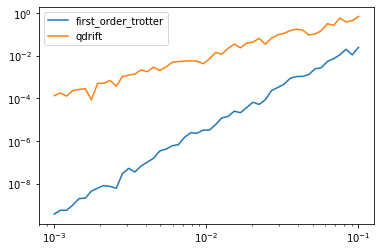

In [4]:
iterations = 1
times = np.geomspace(0.01, 0.5, 50)

first_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order=1)
partition_sim(first_order_trott_sim, "trotter")

second_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order = 2)
partition_sim(second_order_trott_sim, "trotter")

qdrift_sim = CompositeSim(hamiltonian_list=hamiltonian_list)
partition_sim(qdrift_sim, "qdrift")

comp_sim = CompositeSim(hamiltonian_list=hamiltonian_list)

def test_infidelity(simulator, t_start=1e-3, t_end=1e-1, t_steps=50, num_state_samples=5, partitions=["first_order_trotter", "qdrift"]):
    times = np.geomspace(t_start, t_end, t_steps)
    results = dict()
    for partition in partitions:
        infs = []
        partition_sim(simulator, partition_type=partition)
        simulator.print_partition()
        for t in times:
            inf = 0
            for _ in range(num_state_samples):
                simulator.randomize_initial_state()
                inf_temp, _ = single_infidelity_sample(simulator, t)
                inf += inf_temp
            infs.append(inf / num_state_samples)
        results[partition] = infs
    results["times"] = times
    for partition, infs in results.items():
        if partition != "times":
            plt.loglog("times", partition, data=results, label=partition)
    plt.legend()
    plt.show()
    
test_infidelity(comp_sim)

## Infidelity Performance
This section compares that our compilers match theoretic predictions for infidelity scaling with respect to time. We keep iterations fixed and compare how the different compilers perform. We will use a simple kronecker product of pauli matrices for baseline testing. For the composite simulation testing we will use the probabilistic partitioning scheme and repartition at each time step with the goal of observing a transition from QDrift to Trotter scaling. 

- What do we do about inputs?

## Trace Distance Performance
This section is similar to the prior, we keep the number of iterations fixed and instead evaluate the Trace Distance.

## Gate Count Performance
We now compare how the gate count of each partitioning type varies across time while each simulator meets a specified threshold in infidelity. In this we search for the smallest number of iterations that meet the infidelity threshold, the iterations then determines the gate count. 

# Partitioning Performance
In this section we look at the relative performance of each type of partitioning, including Trotter and QDrift only partitions, with more involved Hamiltonians. This includes simulations that take a relatively long time to compute. 

## Notebook using compilers.py

The goal is to compare the functions in compilers.py in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

### Trotter Simulation

In [61]:
sim1 = TrotterSim(hamiltonian_list, order = 2)
#sim1.initial_state = InitialState

In [62]:
iterations = 1
tStart = 0.01
tFinal = 0.5
tSteps = 50
times = np.geomspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim1.infidelity(t, iterations))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)
print(sim1.gate_count)

(50,)
16


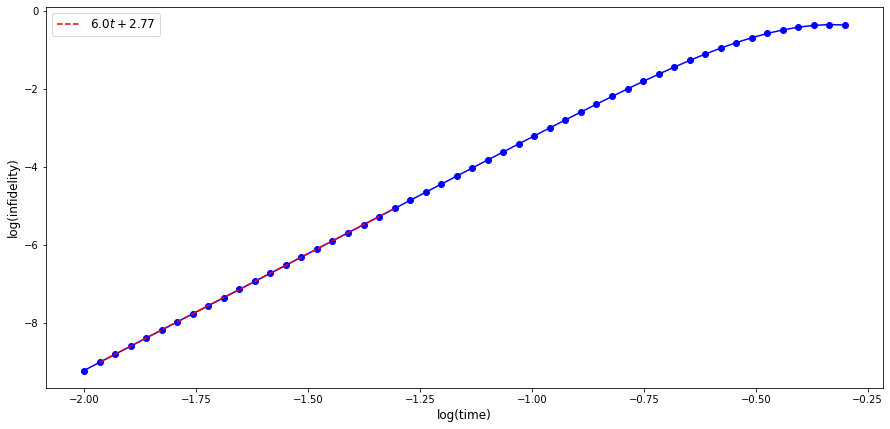

In [63]:
#data = log_trot_compiler_inf[:, 0, 0]
data = log_trot_compiler_inf
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points= 1  #declare the starting point to fit in the data
end_fit_points = -30

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### QDrift Simulation

In [5]:
QDsim = QDriftSim(hamiltonian_list, rng_seed=1)

In [6]:
samples = 20
mc_samples = 200

tStart = 0.001
tFinal = 1
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps) 

qd_compiler_inf = []
for t in times:
    qd_compiler_inf.append(QDsim.sample_channel_inf(t, samples, mc_samples))

log_qd_compiler_inf = np.log10(qd_compiler_inf)
log_times = np.log10(times)
print(log_qd_compiler_inf.shape)
print(QDsim.gate_count)
#print(QDsim.exp_op_cache)

(20,)
20


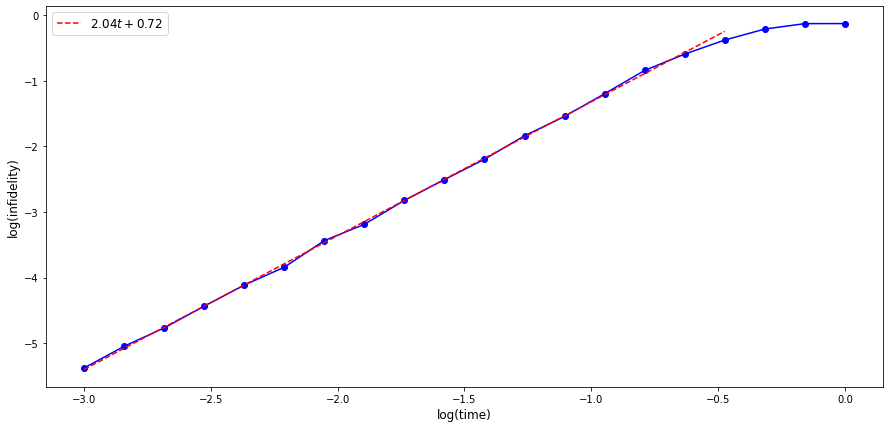

In [7]:
data1 = log_qd_compiler_inf #[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -4

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### Composite Simulation

##### Time Scaling

In [12]:
#Warning if nb_optimizer = True for partition attribute optimize the computation will not finish in your lifetime
CompSim = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition = "chop", weight_threshold = 0.1, nb = 8, nb_optimizer = False, initial_time = 0.1, epsilon = 0.05)
#CompSim.simulate(0.1, 8, 2)
#CompSim.repartition(1)

There are 10 terms in Trotter
There are 26 terms in QDrift


In [13]:
#startTime = time.time()

iterations = 10
qd_samples = 8
mc_samples = 100

tStart = 0.001
tFinal = 0.5
tSteps = 40
times = np.geomspace(tStart, tFinal, tSteps)

comp_compiler_inf = []
for t in times:
    comp_compiler_inf.append(CompSim.sample_channel_inf(t, qd_samples, iterations, mc_samples, exact_time_evolution(CompSim.unparsed_hamiltonian, t, CompSim.initial_state)))

log_comp_compiler_inf = np.log10(comp_compiler_inf)
log_times = np.log10(times)
print(log_comp_compiler_inf.shape)
print(CompSim.gate_count)

#executionTime = (time.time() - startTime)
#print('Execution time in seconds: ' + str(executionTime))

KeyboardInterrupt: 

8


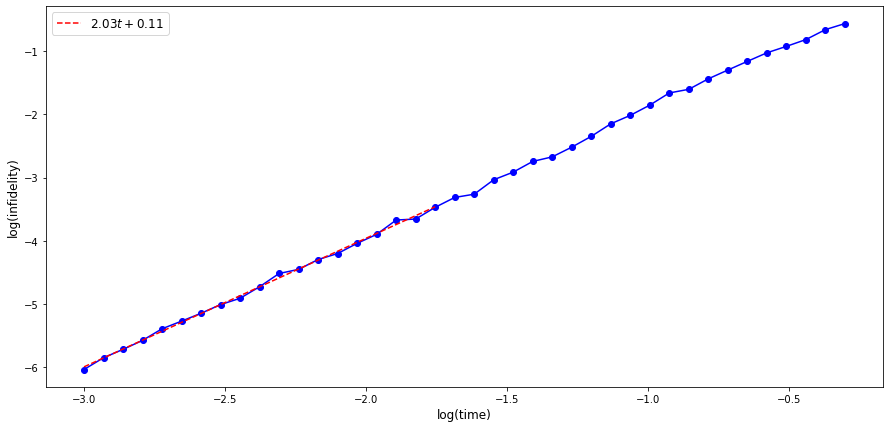

In [13]:
print(CompSim.nb)
data1 = log_comp_compiler_inf #this dimension issue might be causing some slow down
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -22

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

#### Channel Gate Performance using sim_channel_performance()

In [13]:
#Load sims and test Monte-Carlo
CompSim1 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=0.1, partition="prob", nb = , nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
QDSim1  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)

t = 0.1
samples = 120
iterations = 1
sample_guess = 4
mcsamples = 200
#mcsamples = QDSim1.sample_decider(t, samples, iterations, sample_guess) #needs to be evaluated in a region known to be convergent
print(mcsamples)

Nb is 16
There are 12 terms in Trotter
There are 13 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 0 terms in Trotter
There are 25 terms in QDrift
200


In [14]:
data1 = CompSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data2 = TrotSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data3 = TrotSim2.sim_channel_performance(t, samples, iterations, mcsamples)
#data4 = QDSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#print('We require ' + str(data2)  +' gates to meet an epsilon of ' + str(CompSim1.epsilon))

[sim_channel_performance] Iterations too large, already below error threshold


In [15]:
print(data1, len(CompSim1.a_norms), len(CompSim1.b_norms))
plt.figure(figsize = (15, 7))
plt.plot(QDSim1.gate_data[:,0], QDSim1.gate_data[:,1], 'go-') 
plt.xlabel('gate count', size = 12)
plt.ylabel('infidelity', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -1
order = 1

p = np.polyfit(QDSim1.gate_data[:,0][start_fit_points: end_fit_points], QDSim1.gate_data[:,1][start_fit_points: end_fit_points], order)
f = np.poly1d(p)

t_new = np.linspace(QDSim1.gate_data[:,0][start_fit_points], QDSim1.gate_data[:,0][end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'b--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

144 12 13


TypeError: list indices must be integers or slices, not tuple

<Figure size 1080x504 with 0 Axes>

### Long Sim Analyzer

In [8]:
#beware of runtime
CompSim = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=0.01, partition="optimal prob", nb_optimizer=False, weight_threshold=0.5, epsilon=0.001)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", epsilon=0.001)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", epsilon=0.001)
QDSim  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", epsilon=0.001)

iterations = 1
samples = 1
mc_samples = 150

tStart = 0.1
tFinal = 2
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps)

CompSim_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()
QDSim_results = dict()

partition_dist = []

for t in times:
    #CompSim.repartition(t)
    #CompSim_results[t] = CompSim.sim_channel_performance(t, samples, iterations, mc_samples) #uncomment for non-optimized methods
    
    CompSim.time = t
    CompSim.partitioning(weight_threshold=2)
    CompSim_results[t] = CompSim.optimized_gatecost
    partition_dist.append([len(CompSim.a_norms), len(CompSim.b_norms)])
    TrotSim1_results[t] = TrotSim1.sim_channel_performance(t, samples, iterations, mc_samples)
    TrotSim2_results[t] = TrotSim2.sim_channel_performance(t, samples, iterations, mc_samples)
    QDSim_results[t] = QDSim.sim_channel_performance(t, samples, iterations, mc_samples)

partition_dist = np.array(partition_dist)

outfile = open("sim_channel_performance_with_prob_repartitioning_June_01.json", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()
    

Nb is 8
There are 12 terms in Trotter
There are 13 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
Nb is 25
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 27
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 29
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 32
[sim_channel_performance] Iterations too large, already below error threshold
[

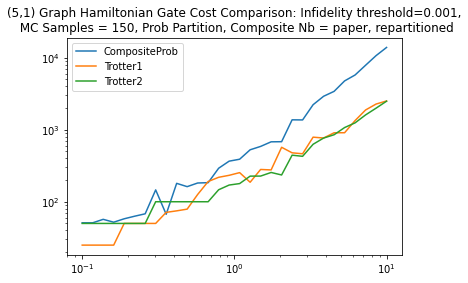

In [9]:

plt.title("(5,1) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.001,\n MC Samples = 150, Prob Partition, Composite Nb = paper, repartitioned")
plt.loglog(times, list(CompSim_results.values()), label="CompositeProb")
plt.loglog(times, list(TrotSim1_results.values()), label="Trotter1")
plt.loglog(times, list(TrotSim2_results.values()), label="Trotter2")
#plt.loglog(times, list(QDSim_results.values()), label="QDrift")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

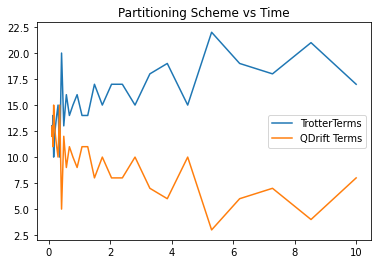

In [10]:
plt.title("Partitioning Scheme vs Time")
plt.plot(times, partition_dist[:,0], label="TrotterTerms")
plt.plot(times, partition_dist[:,1], label = "QDrift Terms")
#plt.plot(times, partition_dist[:,0]/partition_dist[:,1], label = "A/B ratio")
plt.legend()
plt.show

# Code Profiling

In [6]:
#Use the @profile decorator above any function in the notebook 
# and then simply execute the function from the classes defined below
QDtest = QDriftSim(graph_hamiltonian_list)
TrotTest = TrotterSim(graph_hamiltonian_list, order = 2)
CompTest = CompositeSim(graph_hamiltonian_list, inner_order =2, partition = "prob")

Nb is 28
There are 11 terms in Trotter
There are 5 terms in QDrift


In [9]:
CompTest.simulate(1, 40, 500)

         218970 function calls (218942 primitive calls) in 0.653 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.653    0.653 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:709(simulate)
      500    0.066    0.000    0.584    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:369(simulate)
      500    0.154    0.000    0.495    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:355(draw_hamiltonian_samples)
    14500    0.013    0.000    0.331    0.000 <__array_function__ internals>:2(sum)
16206/16179    0.013    0.000    0.327    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    14500    0.030    0.000    0

array([[ 0.04657303+8.98447138e-03j],
       [-0.0081226 -1.05209938e-01j],
       [ 0.00043893+4.53157983e-03j],
       [ 0.0104241 -1.15266977e-02j],
       [-0.03289562+1.12467799e-01j],
       [ 0.26043223+4.73684174e-03j],
       [-0.01007516-1.15135397e-03j],
       [ 0.01950316+2.80811059e-02j],
       [ 0.05212141-1.40581937e-01j],
       [-0.3312342 -2.74534659e-02j],
       [ 0.01443539-5.90420141e-04j],
       [-0.03004891-3.93644517e-02j],
       [ 0.34153119+1.03827494e-01j],
       [ 0.02018393-7.92414014e-01j],
       [-0.00339412+2.90928113e-02j],
       [ 0.08686583-6.11311439e-02j]])

# Density Matrix Sim

In [109]:
dms = DensityMatrixSim(hamiltonian_list = jellium_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", weight_threshold= 0.01, state_rand=True, pure=False)
#dms.sim_trace_distance(0.01, 11, 1)
print(dms.spectral_norms)

mixed states not supported
There are 56 terms in Trotter
There are 0 terms in QDrift
[98.19868481373146, 39.27947392549255, 9.670660722224486, 9.670660722224486, 39.27947392549255, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.1989436788648692, 0.019894367886486918, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.019894367886486918, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.029841551829730383, 0.019894367886486918, 0.019894367886486918, 0.02984

In [110]:
iterations = 4
qd_samples = 1

tStart = 0.001
tFinal = 0.2
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps)

trace_distance = []
for t in times:
    trace_distance.append(dms.sim_trace_distance(t, qd_samples, iterations))

log_trace_distance = np.log10(trace_distance)
log_times = np.log10(times)
#print(log_trace_distance.shape)
print(dms.gate_count)

448


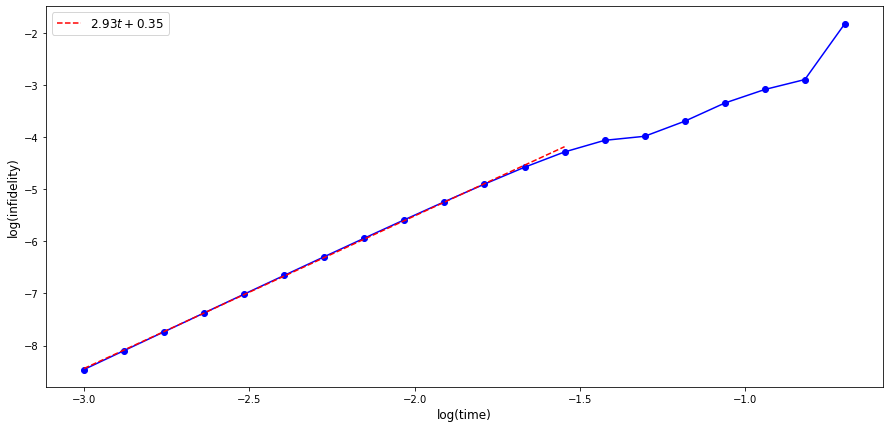

In [111]:
data1 = log_trace_distance #[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

start_fit_points=0 #declare the starting point to fit in the data
end_fit_points = -8

p = np.polyfit(log_times[start_fit_points: end_fit_points], data1[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [18]:
#beware of runtime
tStart = 0.01/10
tFinal = 1.5/10
tSteps = 15
times = np.geomspace(tStart, tFinal, tSteps)

CompSim = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=tStart, partition="prob", nb=15, nb_optimizer=False, weight_threshold=0.5, pure=False, epsilon=0.0001)
CompSim2 = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=tStart, partition="prob", nb=15, nb_optimizer=True, weight_threshold=0.5, pure=False, epsilon=0.0001)
TrotSim1 = DensityMatrixSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", pure = True, epsilon=0.0001)
TrotSim2 = DensityMatrixSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", pure = True, epsilon=0.0001)
QDSim  = DensityMatrixSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", pure = False, epsilon=0.0001)

CompSim_results = dict()
CompSim2_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()

partition_dist = [] #partition distribution
nb_t = []

for t in times:
    CompSim.time = t
    CompSim.repartition(t)
    CompSim_results[t] = CompSim.sim_channel_performance(t) #uncomment for non-optimized methods
    #CompSim_results[t] = CompSim.optimized_gatecost
    partition_dist.append([len(CompSim.a_norms), len(CompSim.b_norms)])
    nb_t.append(CompSim.nb)

    CompSim2.time = t
    CompSim2.repartition(t)
    CompSim2_results[t] = CompSim2.sim_channel_performance(t)
    #CompSim2_results[t] = CompSim2.optimized_gatecost
    partition_dist.append([len(CompSim2.a_norms), len(CompSim2.b_norms)])
    nb_t.append(CompSim2.nb)

    TrotSim1_results[t] = TrotSim1.sim_channel_performance(t)
    TrotSim2_results[t] = TrotSim2.sim_channel_performance(t)
    print("AT TIME " + str(t))


mixed states not supported
Nb is 11
There are 19 terms in Trotter
There are 24 terms in QDrift
mixed states not supported
Nb is 10
There are 43 terms in Trotter
There are 0 terms in QDrift
Nb is equal to 10
There are 43 terms in Trotter
There are 0 terms in QDrift
There are 43 terms in Trotter
There are 0 terms in QDrift
mixed states not supported
There are 0 terms in Trotter
There are 43 terms in QDrift
Nb is 11


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


[sim_channel_performance] Iterations too large, already below error threshold
Nb is 10
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
AT TIME 0.001
Nb is 13
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 13
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
AT TIME 0.0014303261869275461
Nb is 15
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 15
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, alrea

In [13]:
QDSim_results = dict()
for t in times[:8]:
    QDSim_results[t] = QDSim.sim_channel_performance(t)
    print("AT QD TIME " + str(t))

partition_dist = np.array(partition_dist)
nb_t = np.array(nb_t)

outfile = open("sim_channel_performance_with_optimized_repartitioning_June_13.json", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()

AT QD TIME 0.001
AT QD TIME 0.0014303261869275461
AT QD TIME 0.002045833001010693
AT QD TIME 0.0029262085154261636
AT QD TIME 0.00418543266802442
AT QD TIME 0.005986533948697348
AT QD TIME 0.008562696275752584
AT QD TIME 0.012247448713915893


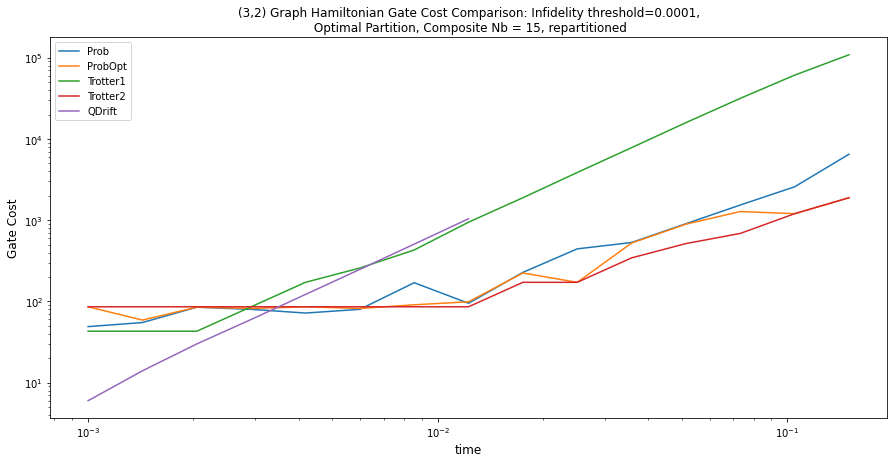

In [19]:
plt.figure(figsize = (15, 7))
plt.title("(3,2) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.0001,\n Optimal Partition, Composite Nb = 15, repartitioned")
plt.xlabel('time', size = 12)
plt.ylabel('Gate Cost', size = 12)
plt.loglog(times, list(CompSim_results.values()), label="Prob")
plt.loglog(times, list(CompSim2_results.values()), label="ProbOpt")
plt.loglog(times, list(TrotSim1_results.values()), label="Trotter1")
plt.loglog(times, list(TrotSim2_results.values()), label="Trotter2")
plt.loglog(times[:8], list(QDSim_results.values())[:8], label="QDrift")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (15,) and (45,)

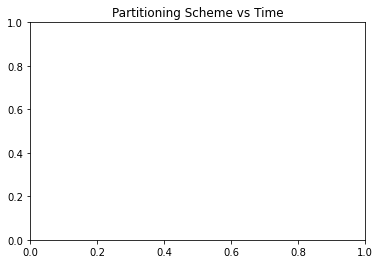

In [17]:
plt.title("Partitioning Scheme vs Time")
plt.plot(times, partition_dist[:,0], label="TrotterTerms")
plt.plot(times, partition_dist[:,1], label = "QDrift Terms")
plt.plot(times, nb_t, label = "nb")
plt.legend()
plt.show